In [1]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=1000,n_features=20,centers=3,cluster_std=1.0,random_state=0)

In [ ]:
def custom_pca(X, keep_dims=None, var_threshold=None, method='eig'):
    import numpy as np
    """
    Simple PCA supporting either:
      * keep_dims=int   → keep exactly that many PCs (and report % variance explained)
      * var_threshold=0.9 → keep as many PCs as needed to reach that fraction (and report # PCs)
    Exactly one of keep_dims or var_threshold must be provided.
    One method for muse also be provided. Suport for:
      *Eigen decomposition=eig (default)
      *Singular Value Decomposition=svd
    """
    # 0. check inputs
    if (keep_dims is None) == (var_threshold is None):
        raise ValueError("Specify exactly one of keep_dims or var_threshold")

    # 1. center data
    mu = np.mean(X, axis=0)
    Xc = X - mu
    n, p = Xc.shape

    # 2. Compute factorization based on selected method
    if method == 'eig':
        # 2a. Compute covariance matrix and its eigen decomposition
        C = np.cov(Xc, rowvar=False)
        eigvals, eigvecs = np.linalg.eig(C)
        idx = np.argsort(eigvals)[::-1]
        eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]
        loadings_all = eigvecs
    elif method == 'svd':
        # 2b. Use singular value decomposition
        U, S, Vt = np.linalg.svd(Xc, full_matrices=False)
        eigvals = (S**2) / (n - 1)
        loadings_all = Vt.T
    else:
        raise ValueError("method must be 'eig' or 'svd'")

    # 3. explained‐variance ratios
    var_ratios = eigvals / np.sum(eigvals)

    # 4. Select number of components based on variance threshold or fixed count
    if var_threshold is not None:
        cumvar = np.cumsum(var_ratios)
        keep_dims = np.searchsorted(cumvar, var_threshold) + 1
        print(f"► Selected {keep_dims} PCs to explain ≥{var_threshold*100:.1f}% of variance")
    else:
        explained = np.sum(var_ratios[:keep_dims])
        print(f"► Keeping {keep_dims} PCs, which explain {explained*100:.1f}% of variance")

    # 5. Ensure consistent sign of loadings for reproducibility
    for j in range(loadings_all.shape[1]):
        pc = loadings_all[:, j]
        if pc[np.argmax(np.abs(pc))] < 0:
            loadings_all[:, j] = -pc
    # 6. Project centered data onto the selected principal components
    loadings = loadings_all[:, :keep_dims]
    Z = Xc @ loadings

    return Z, loadings, var_ratios


► Selected 2 PCs to explain ≥90.0% of variance
► Selected 2 PCs to explain ≥90.0% of variance


► Selected 2 PCs to explain ≥90.0% of variance
► Keeping 2 PCs, which explain 95.8% of variance


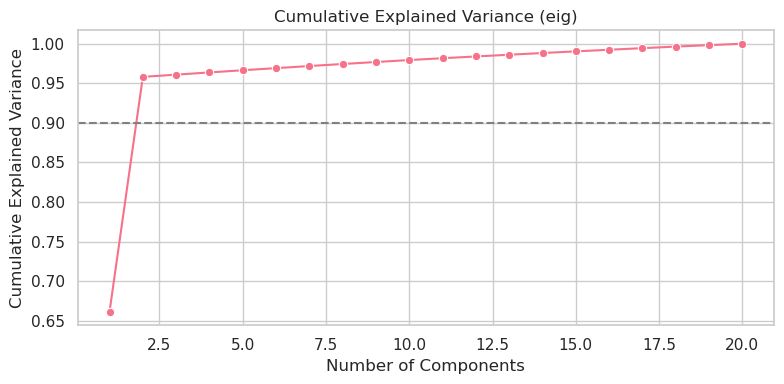

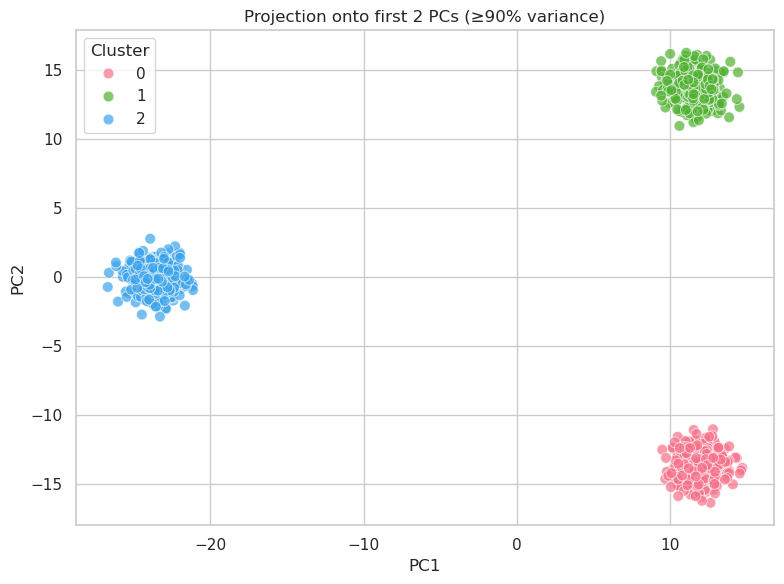

► Keeping 2 PCs, which explain 95.8% of variance
► Keeping 2 PCs, which explain 95.8% of variance


In [61]:
import matplotlib.pyplot as plt
import seaborn as sns
# 1) PCA to retain ≥90% variance
Z90, L90, vr90 = custom_pca(X, var_threshold=0.9, method='eig')
Z2, L2, vr2 = custom_pca(X, keep_dims=2, method='svd')
cumvar90 = np.cumsum(vr90)
dims90 = Z90.shape[1]
sns.set_theme(style="whitegrid", palette="husl")
plt.figure(figsize=(8, 4))
sns.lineplot(x=np.arange(1, len(vr90)+1), y=cumvar90, marker="o")
plt.axhline(0.9, linestyle='--', color='gray')
plt.title('Cumulative Explained Variance (eig)')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.tight_layout()
plt.show()
plt.figure(figsize=(8, 6))
sns.scatterplot(x=Z90[:,0], y=Z90[:,1], hue=y.astype(str), palette="husl", s=60, alpha=0.7)
plt.title(f'Projection onto first {Z90.shape[1]} PCs (≥90% variance)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

Z2_eig, _, _ = custom_pca(X, keep_dims=2, method='eig')
Z2_svd, _, _ = custom_pca(X, keep_dims=2, method='svd')

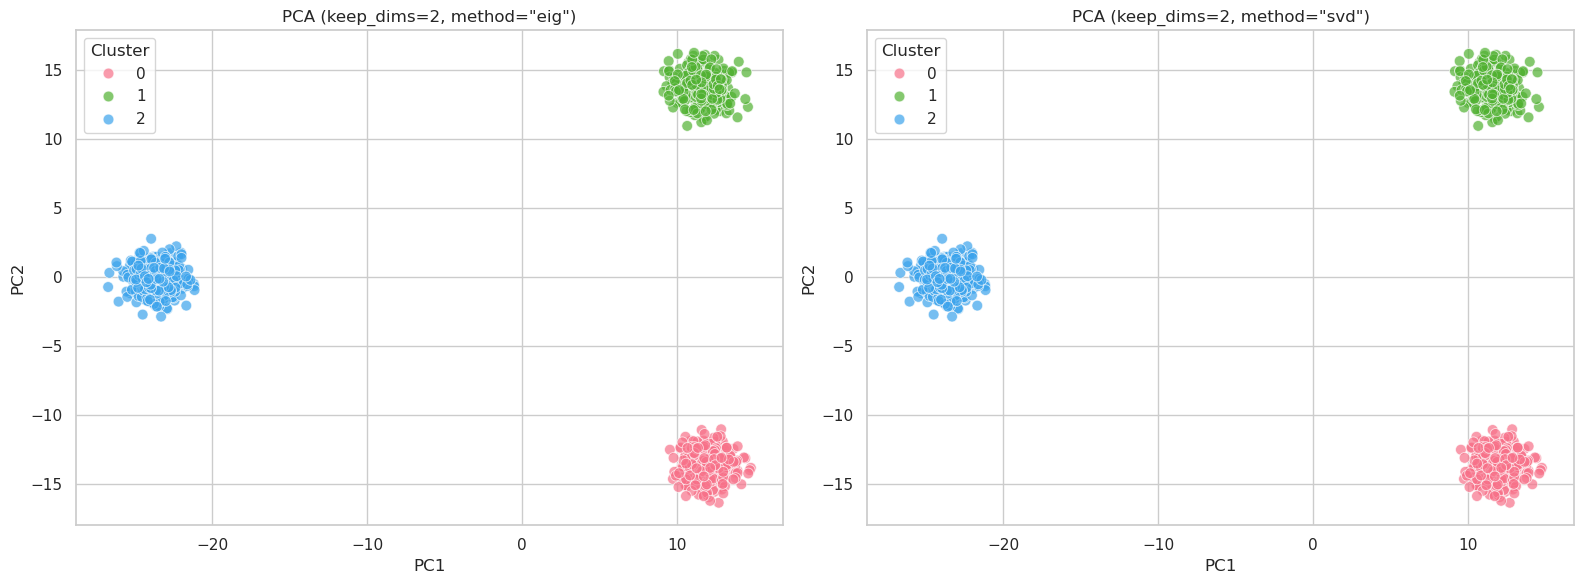

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# assume Z2_eig, Z2_svd, and y are already defined

sns.set_theme(style="whitegrid")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: eigen-decomposition
sns.scatterplot(
    x=Z2_eig[:, 0], y=Z2_eig[:, 1],
    hue=y.astype(str), palette="husl",
    s=60, alpha=0.7, ax=axes[0]
)
axes[0].set_title('PCA (keep_dims=2, method="eig")')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].legend(title="Cluster")

# Right: SVD
sns.scatterplot(
    x=Z2_svd[:, 0], y=Z2_svd[:, 1],
    hue=y.astype(str), palette="husl",
    s=60, alpha=0.7, ax=axes[1]
)
axes[1].set_title('PCA (keep_dims=2, method="svd")')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].legend(title="Cluster")

plt.tight_layout()
plt.show()


In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Compute PCA loadings (make sure your custom_pca is already defined)
# Returns: Z, loadings, var_ratios
_, _, _, loadings = custom_pca(X, keep_dims=2, method='eig')

# Take absolute values of the first two loading vectors
abs_loadings = np.abs(loadings[:, :2])

# Create the scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(abs_loadings[:, 0], abs_loadings[:, 1], c='b', marker='o')

# Highlight the region where both loadings exceed 0.4
plt.axvspan(0.4, 1.0, color='red', alpha=0.1)
plt.axhspan(0.4, 1.0, color='red', alpha=0.1)
plt.fill_betweenx([0.4, 1.0], 0.4, 1.0, color='red', alpha=0.1)

# Labels and title
plt.title('Absolute Loadings of the First Two Principal Components')
plt.xlabel('Absolute Loading of PC1')
plt.ylabel('Absolute Loading of PC2')

# Annotate each point
for i in range(abs_loadings.shape[0]):
    plt.text(
        abs_loadings[i, 0], abs_loadings[i, 1],
        f'F_{i+1}', fontsize=9,
        ha='right', va='bottom'
    )

plt.tight_layout()
plt.show()


► Keeping 2 PCs, which explain 95.8% of variance


ValueError: not enough values to unpack (expected 4, got 3)